# Name of People who have worked on this project : Viraj Kadam

# Link to the Presentation Video : [ https://drive.google.com/file/d/1ESl1O6J5El6hmG-quLQ2QcRKPIDMPss1/view?usp=sharing ]

* **The presentation slides are uploaded with this notebook**

# Notebook Description
* **1) Aggregating the data for countries, and making the features similar for modelling purposes** 
* **2) Exploratory Data Analysis with the COVID-19 data from India, Brazil and South Korea and Italy**
* **There are some assumptions made, they may not be necessarily completely valid for the full data. They are :**
    * **India went into lockdown early.**
    * **Italy went into lockdown late.**
    * **South Korea followed a good contact tracing policy**
* **3) Making covid 19 models for countries (other than brazil) and evaluating on brazil**
    

# Imports 

In [1]:
# general
import pandas as pd 
import os
import numpy as np
import warnings 

# plotting 
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('Solarize_Light2')

#Modelling
from sklearn.linear_model import Lasso,Ridge
from sklearn.preprocessing import PolynomialFeatures as PF 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import cross_validate


warnings.filterwarnings('ignore')

# Helper Functions 

In [2]:
def to_datetime(df,date_col,frmt = None):
    '''convert a date column from dataframe to datetime object'''
    
    df[date_col] = pd.to_datetime(df[date_col],format = frmt)
    
    
    # base year as 2020, 1 if year == 2021 :
    y = df[date_col].dt.year - 2020
    
    # add a week number (the second term if year == 2021)
    df['week'] = df[date_col].dt.week + (y * 52)
    
    df.drop(date_col,axis=1,inplace=True)
    
    return df    


# plotting functions
def plot_deaths(country_dfs:list,country_name:list,color_dict:dict):
    ''' plot of weekly deaths'''
   
    fig,ax=plt.subplots(figsize = (12,7))
    
    plt.title('Cumulative Deaths (weekly)')
    for i,country in enumerate(country_dfs):
        
        name = country_name[i]
        
        temp_df = country.groupby('week').agg({'deaths':'max'})
        
        x=temp_df.index
        y=temp_df.deaths/1000
        
        plt.plot(x,y,label = name, color = color_dict[name])
        
        
    plt.xlabel('Weeks since Start')
    plt.ylabel('Number of deaths reported (in Thousands)')
    plt.legend(fontsize= 'large')
    plt.savefig('cm_deaths.png')
    plt.show()

    
def plot_cases(country_dfs:list,country_name:list,color_dict:dict):
    '''plot a scatter plot of weekly cases'''
   
    fig,ax=plt.subplots(figsize = (12,7))
    
    plt.title('Cumulative cases (weekly)')
    for i,country in enumerate(country_dfs):
        
        name = country_name[i]
        temp_df = country.groupby('week').agg({'cases':'max'})
        
        x=temp_df.index
        y=temp_df['cases']/1000000
        
        plt.plot(x,y,label = name, color = color_dict[name])
        
        
    plt.xlabel('Weeks since Start')
    plt.ylabel('Number of cases reported(in millions)')
    plt.legend(fontsize= 'large')
    plt.savefig('cm_cases.png')
    plt.show()
    
    
def plot_active_cases(country_dfs:list,country_name:list,color_dict:dict):
    '''plot a scatter plot of weekly active cases'''
   
    fig,ax=plt.subplots(figsize = (12,7))
    
    plt.title('Active cases (weekly)')
    for i,country in enumerate(country_dfs):
        
        name = country_name[i]
        temp_df = country.groupby('week').agg({'active':'max'})
        
        x=temp_df.index
        y=temp_df['active']/1000
        
        plt.plot(x,y,label = name, color = color_dict[name])
        
        
    plt.xlabel('Weeks since Start')
    plt.ylabel('Number of cases active (in Thousands)')
    plt.legend(fontsize= 'large')
    plt.savefig('active_cases.png')
    plt.show()


def plot_recoveries(country_dfs:list,country_name:list,color_dict:dict):
    '''plot a scatter plot of weekly cases'''
   
    fig,ax=plt.subplots(figsize = (12,7))
    
    plt.title('Cumulative Recoveries (weekly)')
    for i,country in enumerate(country_dfs):
        
        name = country_name[i]
        
        temp_df = country.groupby('week').agg({'recovered':'sum'})
        
        x=temp_df.index
        y=temp_df['recovered']/10000
        
        plt.plot(x,y,label = name, color = color_dict[name])
        
        
    plt.xlabel('Weeks since Start')
    plt.ylabel('Number of recoveries reported (in Ten Thousands)')
    plt.legend(fontsize= 'large')
    plt.savefig('cm_recoveries.png')
    plt.show()

    
    
def plot_cfr(country_dfs:list,country_name:list,color_dict:dict):
    '''plot a scatter plot of weekly cases'''
   
    fig,ax=plt.subplots(figsize = (12,7))
    
    plt.title('Case Fatality rate (weekly)')
    for i,country in enumerate(country_dfs):
        
        name = country_name[i]
        
        temp_df = country.groupby('week').agg({'cfr':'mean'})

        plt.plot(temp_df.index,temp_df['cfr'],label = name, color = color_dict[name])
        
        
    plt.xlabel('Weeks since Start')
    plt.ylabel('Mean Case Fatality Rate')
    plt.legend(fontsize= 'large')
    plt.savefig('cfr.png')
    plt.show()
    

def plot_m_cfr(country_dfs:list,country_name:list,color_dict:dict):
    '''plot a scatter plot of weekly cases'''
   
    fig,ax=plt.subplots(figsize = (12,7))
    
    plt.title('Marginal Case Fatality rate (weekly)')
    
    for i,country in enumerate(country_dfs):
        
        name = country_name[i]
        
        temp_df = country.groupby('week').agg({'marginal_cfr':'mean'})

        plt.plot(temp_df.index,temp_df['marginal_cfr'],label = name, color = color_dict[name])
        
        
    plt.xlabel('Weeks since Start')
    plt.ylabel('Mean Marginal Case Fatality Rate')
    plt.legend(fontsize= 'large')
    plt.savefig('marg_cfr.png')
    plt.show()

# Loading Data 

In [3]:
brazil_covid = pd.read_csv('../input/corona-virus-brazil/brazil_covid19_macro.csv')
india_covid = pd.read_csv('../input/covid19-in-india/covid_19_india.csv')
italy_covid = pd.read_csv('../input/covid19-in-italy/covid19_italy_region.csv')
s_korea = pd.read_csv('../input/coronavirusdataset/TimeProvince.csv')


# add datetime feat 
brazil_covid = to_datetime(brazil_covid,'date')

brazil_covid.drop(['monitoring','country'],axis=1,inplace=True)

In [4]:
# for the year 2020

# 1) saving the populations of each country (in Millions) in these variables 
# 2) saving per capita gdp in terms of purchasing power parity $ 
# 3) saving healthcare budget as % of gdp 

stats_dict={    'india':  {'population':1378.6, 'gdp_ppp': 6390 ,'healthcare': 1.5},
                'italy':  {'population':59.6,  'gdp_ppp': 42270 ,'healthcare': 9.7} ,
                'brazil': {'population':211.76,'gdp_ppp': 14550 ,'healthcare': 9.5},
                's_korea':{'population':51.78, 'gdp_ppp': 42250 ,'healthcare': 8}
           }


# Aggregating the data by date  

In [5]:
# grouping the India data together by date 
india_cov = india_covid.groupby('Date').agg({'Cured': 'sum',
                                             'Confirmed': 'sum',
                                             'Deaths': 'sum'})
# reset index
india_cov.reset_index(inplace=True)

# adding datetime feat as above 
india_cov= to_datetime(india_cov,'Date')


# grouping the Italy provincial data by date
italy_cov = italy_covid.groupby('Date').agg({'CurrentPositiveCases': 'sum',
                                             'NewPositiveCases': 'sum' ,
                                             'Deaths': 'sum',
                                             'Recovered':'sum',
                                             'TotalPositiveCases':'sum'})
# reset index
italy_cov.reset_index(inplace=True)

# adding datetime feat as above 
italy_cov= to_datetime(italy_cov,'Date')


# grouping south koreas data
skorea_cov = s_korea.groupby('date').agg({'confirmed': 'sum',
                                          'deceased'  :'sum',
                                          'released'  :'sum'})
# reset index
skorea_cov.reset_index(inplace=True)

# adding datetime feat as above 
skorea_cov= to_datetime(skorea_cov,'date')



**Rename columns in datasets, so that they match across all the datasets**

In [6]:
# changing the variable names to match all the data 
india_rename = {'Cured':'recovered',
                'Confirmed':'cases',
                'Deaths':'deaths'}

italy_rename = {'CurrentPositiveCases':'active' ,
               'NewPositiveCases' : 'new_cases',
               'Deaths': 'deaths' ,
               'TotalPositiveCases': 'cases',
               'Recovered' : 'recovered'
               }

skorea_rename = {'confirmed' : 'cases',
                'deceased'   : 'deaths',
                'released'   : 'recovered'}


# rename columns 

india_cov.rename(columns = india_rename,inplace=True)
italy_cov.rename(columns = italy_rename,inplace=True)
skorea_cov.rename(columns = skorea_rename,inplace=True)

# Building New Features

In [7]:

def new_cases(df):
    '''calc new cases'''
    
    #shift by 1 row
    shift = df.cases.shift(1)
    
    df['new_cases'] = df.cases - shift
    
    return df

def new_deaths(df):
    '''calc new deaths'''
    
    #shift by 1 row
    shift = df.deaths.shift()
    
    df['new_deaths'] = df.deaths - shift
    
    return df

def new_recovered(df):
    '''calc new recoveries'''
    
    #shift by 1 row
    shift = df.recovered.shift()
    
    df['new_recovered'] =  df.recovered - shift
    
    return df

def active_cases(df):
    '''calc active cases'''
    
    df['active'] = df.cases - df.recovered
    
    return df

def case_recv_ratio(df):
    '''calc ratio of new cases to recoveries'''
    
    df['crr'] = df['new_cases'] / (df['new_recovered']+1)
    
    return df

def cfr(df):
    '''case fatality rate
    Case fatality rate = deaths/ cases'''
    
    df['cfr'] = df['deaths'] / (df['cases'] +1)
    
    return df

def marginal_cfr(df):
    '''marginal case fatality rate(CFR can vary due to change in testing rate)    
    marginal_cfr = new_deaths/active_cases'''
    
    df['marginal_cfr']= df['new_deaths'] / (df['active']+1)
    
    return df
    

def transform(df,transforms):
    '''perform each function in list transforms on given df and returns a new df'''
    
    df1= df.copy(deep=True)
    
    # evaluate and perform each function in transform list 
    for transf in transforms:

        df1=eval(f'{transf}(df1)')

    return df1



In [8]:
# operations on brazil data
transforms_1=['new_cases','new_deaths','new_recovered','active_cases','cfr','marginal_cfr','case_recv_ratio']

brazil_modelling=transform(df=brazil_covid,
                         transforms=transforms_1)


# dropping nan rows
brazil_modelling.dropna(axis=0,inplace=True)
# reset index
brazil_modelling.reset_index(drop=True,inplace=True)


In [9]:
# operations on India data 
transf_2 = ['active_cases', 'new_cases', 'new_deaths', 'new_recovered','cfr','marginal_cfr','case_recv_ratio']

india_modelling = transform(df=india_cov,
                         transforms=transf_2)

# restricting data to 2020 for plotting
india_modelling2 = india_modelling[india_modelling['week']<53]
# dropping nan rows
india_modelling.dropna(axis=0,inplace=True)
#reset index
india_modelling.reset_index(drop=True,inplace=True)


In [10]:
# operations on Italy data set 
transf_3 = ['new_deaths', 'new_recovered','cfr','marginal_cfr','case_recv_ratio']
italy_modelling = transform(df=italy_cov,
                         transforms=transf_3)
# dropping nan rows
italy_modelling.dropna(axis=0,inplace=True)
#reset index
italy_modelling.reset_index(drop=True,inplace=True)

In [11]:
# operations on south korea 
transf_4 = ['active_cases', 'new_cases', 'new_deaths', 'new_recovered','cfr','marginal_cfr','case_recv_ratio']
skorea_modelling = transform(df=skorea_cov,
                         transforms=transf_4)
# dropping nan rows
skorea_modelling.dropna(axis=0,inplace=True)
#reset index
skorea_modelling.reset_index(drop=True,inplace=True)

# -------Data Processed till here ------

# Exploratory data Analysis

In [12]:
# list of data frame
countries_df = [india_modelling2,italy_modelling,skorea_modelling]

countries_name = ['India','Italy','South Korea']

# color representation dict for plots
color_dict = {'India': 'k',
             'Italy' : 'b',
             'South Korea': 'g'}


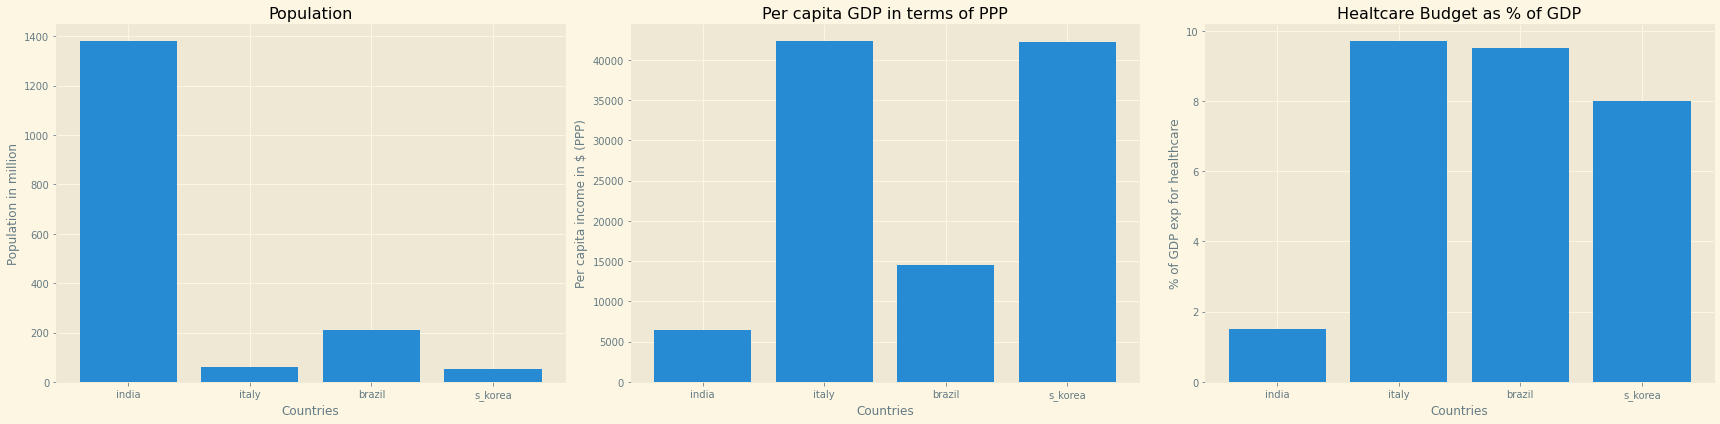

In [13]:
# comparison some socio economic factors 

plt.subplots(1,3,figsize=(24,6))

# Population 
plt.subplot(1,3,1)
plt.bar(x=list(stats_dict.keys()),height=[k['population'] for i,k in stats_dict.items()])
plt.title('Population')
plt.xlabel('Countries')
plt.ylabel('Population in million')

#GDP PPP
plt.subplot(1,3,2)
plt.bar(x=list(stats_dict.keys()),height=[k['gdp_ppp'] for i,k in stats_dict.items()])
plt.title('Per capita GDP in terms of PPP')
plt.xlabel('Countries')
plt.ylabel('Per capita income in $ (PPP)')

# % of national income as healthcare budget
plt.subplot(1,3,3)
plt.bar(x=list(stats_dict.keys()),height=[k['healthcare'] for i,k in stats_dict.items()])
plt.title('Healtcare Budget as % of GDP')
plt.xlabel('Countries')
plt.ylabel('% of GDP exp for healthcare')

plt.tight_layout()

plt.savefig('fig1.png')
plt.show()

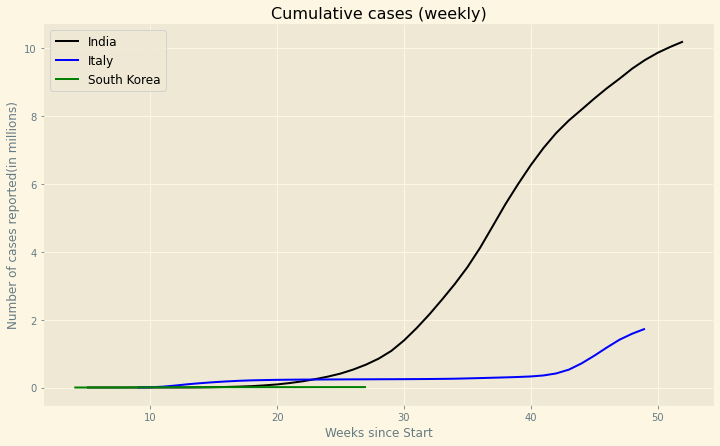

In [14]:
#plot of cumulative cases
plot_cases(countries_df,countries_name,color_dict)

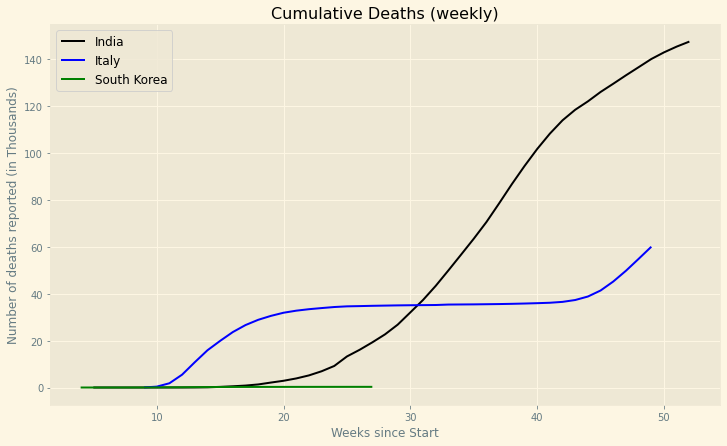

In [15]:
#plot of cumulative deaths
plot_deaths(countries_df,countries_name,color_dict)

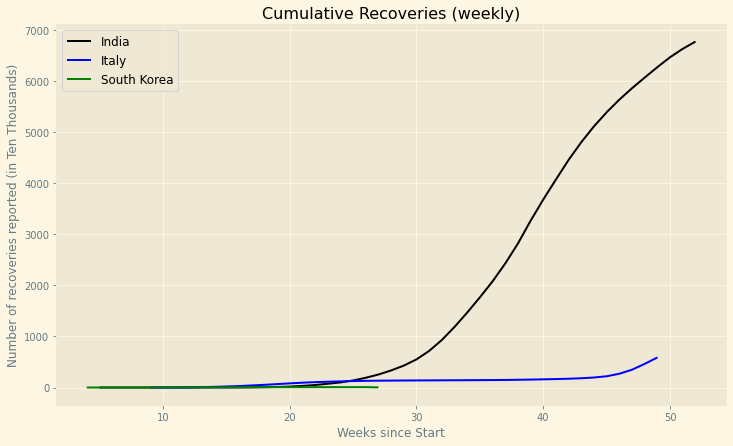

In [16]:
# plot of cumalative recoveries
plot_recoveries(countries_df,countries_name,color_dict)

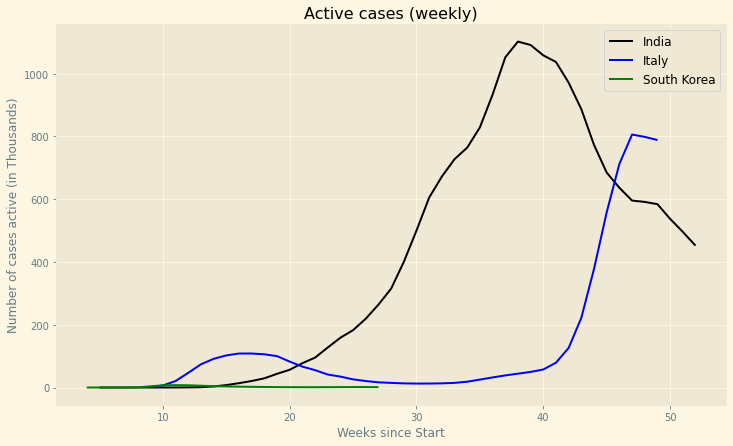

In [17]:
# plot active cases 
plot_active_cases(countries_df,countries_name,color_dict)

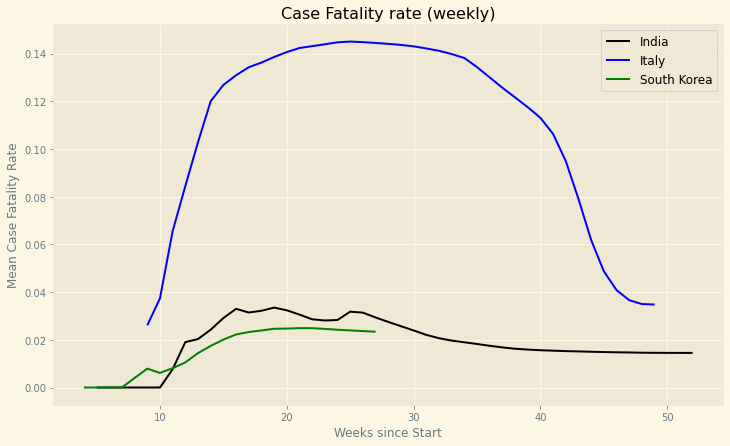

In [18]:
# plot case fatality rate#plot of cumulative cases
plot_cfr(countries_df,countries_name,color_dict)

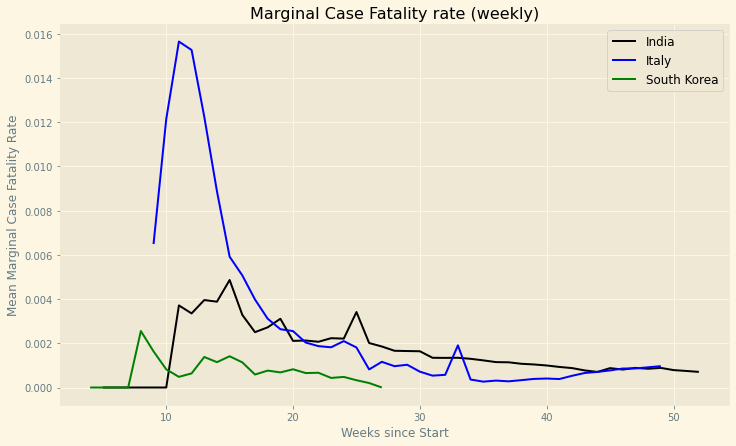

In [19]:
#plot marginal Case Fatality Rate 
plot_m_cfr(countries_df,countries_name,color_dict)


# Modelling with Lasso Regression Model 


* **1) Using new deaths as target variable, to be able to predict new deaths**
* **2) dropping features with 'deaths' and 'case fatality rate' in them.**

In [20]:
# features to be used as predictors 


features = [col for col in india_modelling.columns if (('death' not in col) and ('cfr' not in col))]

# India data 
X_in = india_modelling[features]
y_in = india_modelling['new_deaths']

# italy data 
X_it = italy_modelling[features]
y_it = italy_modelling['new_deaths']

# south korea 
X_sk = skorea_modelling[features]
y_sk = skorea_modelling['new_deaths']

# brazil data 
X_br = brazil_modelling[features]
y_br = brazil_modelling['new_deaths']



In [21]:
def add_polynomial_feats(df):
    '''add polynomial features to the given dataset for time series data'''
    
    pf = PF(include_bias=False,degree = 3)
    
    week_data = pd.DataFrame(pf.fit_transform(df[['week']]),
                             columns = ['week','week^2','week^3'],
                             index = df.index)
    
    df.drop('week',axis=1,inplace=True)
    
    df = df.merge(week_data,left_index=True,right_index=True)
    
    return df
    
    
# adding polynomial time series features 
X_in = add_polynomial_feats(X_in)
X_it = add_polynomial_feats(X_it)
X_br = add_polynomial_feats(X_br)
X_sk = add_polynomial_feats(X_sk)


# check if all cols match

assert set(X_in.columns) == set(X_br.columns) == set(X_sk.columns) == set(X_it.columns) , 'columns donot match'

In [22]:
def find_best_alpha(X,y,alpha_list,cv=3):
    '''find the best fitting value of alpha using cross validation'''
    
    val_mse = []
    
    for alp in alpha_list:
        rid = Ridge(alpha= alp,max_iter=10000,normalize=True)
    
        scores = cross_validate(rid,X,y,cv=cv,
                            return_train_score=False,scoring = 'neg_mean_squared_error')

        
        val_mse.append((-1 * scores['test_score'].mean()))
        
    
    #min mse 
    min_val_mse = min(val_mse)
    
    # best alpha
    best_alpha = alpha_list[np.argmin(val_mse)]
    
    print(f'best alpha value is {best_alpha} ')
    
    return best_alpha
    

In [23]:
def Ridge_model(X, y,name,alpha = None):
    '''return a fitted Lasso regression model on given data  '''
    
    if alpha is None:
        alphas = np.linspace(0.001,1000,100)
        best_alpha = find_best_alpha(X,y,alphas)
        
    model = Ridge(alpha = best_alpha, normalize=True)
    
    #not considering a test set due to small dataset size 
    model.fit(X,y)
    
    train_mse = MAE(y,model.predict(X))
    
    print(f'Train Mean absoulte error for {name} is {train_mse}')
    
    return model
    

# Training the models

In [24]:
# Lasso model on Indian data 

model_india = Ridge_model(X_in, y_in,'Indian Model',alpha = None)

best alpha value is 10.102 
Train Mean absoulte error for Indian Model is 540.1582432049148


In [25]:
# Lasso model on Italy data
model_italy= Ridge_model(X_it, y_it,'Italian Model')

best alpha value is 10.102 
Train Mean absoulte error for Italian Model is 197.95049457474


In [26]:
# Lasso model on Korean data
model_skorea= Ridge_model(X_sk, y_sk,'South Korean Model')

best alpha value is 1000.0 
Train Mean absoulte error for South Korean Model is 1.785359846976876


# Testing model performance on Brazil data 

In [27]:
in_pred = model_india.predict(X_br)
print(f'Mean absoulte error on Brazils new deaths predictions with Indian Model is {MAE(y_br,in_pred)}')

Mean absoulte error on Brazils new deaths predictions with Indian Model is 538.322672281766


In [28]:
it_pred = model_italy.predict(X_br)
print(f'Mean absoulte error on Brazils new deaths predictions with Italy Model is {MAE(y_br,it_pred)}')

Mean absoulte error on Brazils new deaths predictions with Italy Model is 600.3877664251577


In [29]:
sk_pred = model_skorea.predict(X_br)
print(f'Mean absoulte error on Brazils new deaths predictions with South Korean Model is {MAE(y_br,sk_pred)}')

Mean absoulte error on Brazils new deaths predictions with South Korean Model is 1109.3273750724468


# Plot Model predictions 

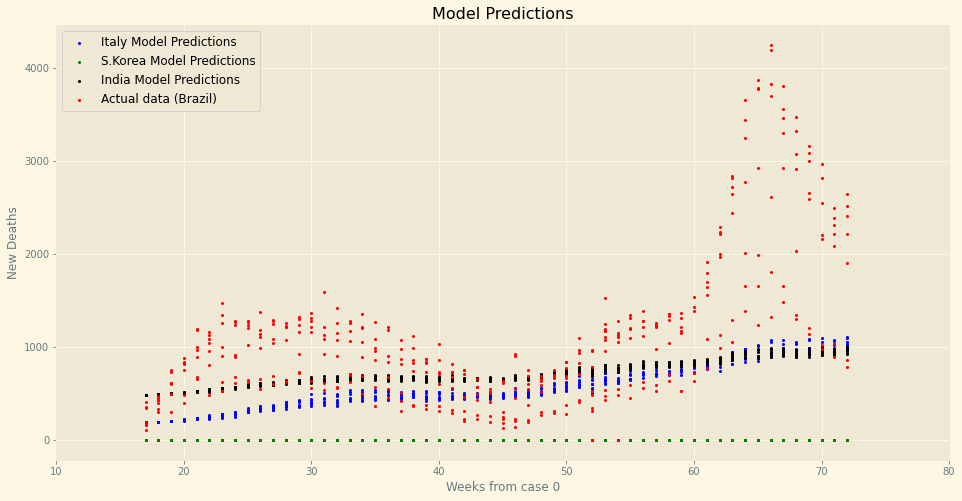

In [30]:
plt.figure(figsize=(16,8))

plt.title('Model Predictions')

#italy model
plt.scatter(x= X_br.week,y= it_pred, label = "Italy Model Predictions",color='b',s = 4)
#south korea model
plt.scatter(x= X_br.week,y= sk_pred, label = "S.Korea Model Predictions",color='g',s =4)
#India model
plt.scatter(x= X_br.week,y= in_pred, label = "India Model Predictions",color='k',s = 4)


# Actual data 
plt.scatter(x= X_br.week,y= y_br, label = "Actual data (Brazil)",color='r',s =4)

plt.legend(loc='upper left',fontsize= 'large')
plt.xlim((10,80))
plt.xlabel('Weeks from case 0')
plt.ylabel('New Deaths')

#save 
plt.savefig('models_pred.png')
plt.show()